## Hierarchical Text Categorization using Watson NLP - pre-trained models

### Use Case 
Hierarchical text categorization provides a more structured and organized approach to categorizing text, enabling better analysis, improved search, and more efficient content management. So Creating a hierarchical categorization system for news articles that is more specific than broad categories like politics, sports, and entertainment. For example, articles on politics can be further categorized into subcategories like crime, war, education etc.

This notebook demonstrates how to use the Explicit Semantic Analysis (ESA) block for performing text categorization. This model has been pre-trained on scrapped web data & news data set.

The data that is used in this notebook is taken from the [kaggle](https://www.kaggle.com/datasets/rmisra/news-category-dataset) News category dataset.

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). The syntax block performs NLP primitive tasks on the input text. It uses Izumo, the standard NLP primitives component of Watson NLP to perform the following tasks:
    1. Sentence detection
    1. Tokenization: can't -> ca + n't
    1. Part-of-Speech tagging: I thought -> I/PRON, thought/VERB
    1. Lemmatization: I thought -> I/I, thought/think
    1. Dependency parsing: I -> nsubj -> thought -> root
    
- **ESA Hierarchical Algorithm** The ESA Hierarchical Algorithm provides a data-free method for hierarchical text categorization. Instead of relying on training data, each label is equipped with a collection of key phrases, represented as n-grams, that are meant to define the semantic scope associated with that label. These key phrases can then be used to obtain an ESA concept vector for the label.

- **Hierarchical Text Categorization** with the ESAHierarchical (`categories_esa_en_stock`),categories block. This pre-train model is useful in Adtech usecases where webpages are categorized into a taxonomy of general domain topics, for advertisement placement and content recommendation. 
   


## Table of Contents

1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing & EDA](#EDA)
1.  [Running Pre-Trained Model](#PTM)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
### 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime xx.x on Python 3.x_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
import json
import os
import pandas as pd

import watson_nlp

from watson_nlp.toolkit.categories import train_esa_utils
from watson_nlp.blocks.categories import ESAHierarchical
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400
import matplotlib.pyplot as plt

<a id="loadData"></a>
## 2. Data Loading (News Dataset)

The dataset contains over 209527 news with categories. The original source of this dataset is from [kaggle](https://www.kaggle.com/datasets/rmisra/news-category-dataset).

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out Text Categorization on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>

<span style="color:blueviolet"><strong>Step 2.1</strong> We load the news category dataset into a DataFrame.</span>

<span style="color:blue">This data set contains 209527 news data with the `link`, `headline`, `category`, `short_description`, `authors` and published `date`.</span>

In [3]:
newsdata_filename = 'News_Category_Dataset_v3.json'
buffer = project.get_file(newsdata_filename)
news_df =pd.read_json(buffer,lines = True)
news_df

link  \
0                                                           https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9   
1       https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe   
2                                          https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02   
3                                                          https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479   
4                         https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c6463e4b09d8701bd227e   
...                                                                                                                                        ...   
209522                                                 https://www.huffingtonpost.com/entry/rim-ceo-thorsten-heins_us_5bb34b8ce4b0fa920b95c4e1   
209523              https://www.huffingtonpost.com/entry/maria-sharapova-stunned-victoria-azarenka-australian-open_us_5bb69b21e4b097869fd1b2f1   
209524                                              https://www.huffingtonpost.com/entry/super-bowl-upsets-the-mos_us_5bb69b1de4b097869fd1b26d   
209525                                         https://www.huffingtonpost.com/entry/aldon-smith-arrested-dui-49ers_us_5bb69b25e4b097869fd1b33c   
209526                             https://www.huffingtonpost.com/entry/dwight-howard-rips-teammates-magic-hornets_us_5bb69b24e4b097869fd1b331   

                                                                                                   headline  \
0                              Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters   
1                 American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video   
2                                     23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23)   
3                                                  The Funniest Tweets From Parents This Week (Sept. 17-23)   
4                             Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer   
...                                                                                                     ...   
209522                                           RIM CEO Thorsten Heins' 'Significant' Plans For BlackBerry   
209523                                Maria Sharapova Stunned By Victoria Azarenka In Australian Open Final   
209524  Giants Over Patriots, Jets Over Colts Among  Most Improbable Super Bowl Upsets Of All Time (VIDEOS)   
209525                                                Aldon Smith Arrested: 49ers Linebacker Busted For DUI   
209526                                             Dwight Howard Rips Teammates After Magic Loss To Hornets   

         category  \
0       U.S. NEWS   
1       U.S. NEWS   
2          COMEDY   
3       PARENTING   
4       U.S. NEWS   
...           ...   
209522       TECH   
209523     SPORTS   
209524     SPORTS   
209525     SPORTS   
209526     SPORTS   

                                                                                                                                                      short_description  \
0            Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.   
1       He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.   
2                                                                                                      "Until you have a dog you don't understand what could be eaten."   
3       "Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his te

<a id="EDA"></a>
## 3. Data Processing & EDA

<span style="color:blueviolet"> <strong>Step 3.1 <strong> Collecting categories of news from data frame</span>

In [4]:
# To see categories wise news dataset
exp_category = news_df.explode('category')

<span style="color:purple">Extract most frequent news categories from dataset</span>

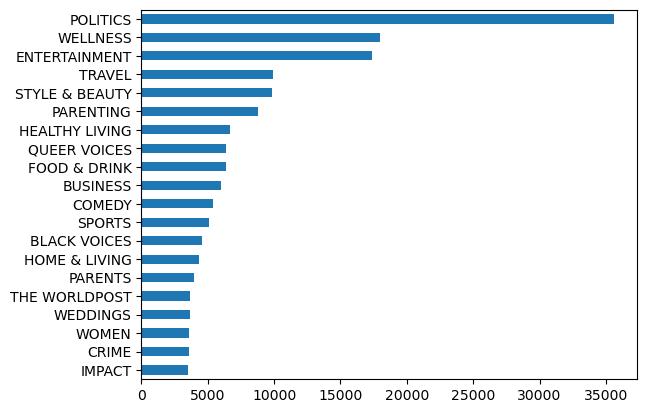

In [5]:
top_categories =exp_category['category'].value_counts().head(20)
top_categories.sort_values().plot(kind='barh') 
plt.show()

In [6]:
print(top_categories)

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
Name: category, dtype: int64


<span style="color:blue">The five most frequent categories in this dataset are: POLITICS, WELLNESS, ENTERTAINMENT, TRAVEL, and STYLE & BEAUTY </span>

 <a id="PTM"></a>
 ## 4. Running Pre-Train Model
Watson NLP has one pretrained/prebuilt Text categorization model using the block catalog system.

<span style="color:blueviolet"> <strong>Step 4.1 <strong> Collecting short_description for the top 5 categories</span>

In [7]:
# extarct short_description data data through the category name 
def extarct_short_description_data(category_name):
    top_doc_list =[]
    for index, row in news_df.iterrows():
        if row['category'] == category_name:
            top_doc_list.append(row['short_description']) 
    return top_doc_list

In [8]:
# getting names of top categories
top_categories_names_list =[]
for index,row in top_categories.items():
    top_categories_names_list.append(index)
    
print("Category Name ---",top_categories_names_list[0]) 

Category Name --- POLITICS


<span style="color:blue">Here we are using Politics category data to categorize more it sub categories</span>

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out Text Categorization on any other news category, you can update the top_categories_names_list number in the next cell</div>

In [9]:
# extarct short_description data data through the category name 
top_doc_list = extarct_short_description_data(top_categories_names_list[0])

In [10]:
print(len(top_doc_list))

35602


In [11]:
help(watson_nlp.blocks.categories.ESAHierarchical.run)

Help on function run in module watson_nlp.blocks.categories.esa_hierarchical.esa_hierarchical:

run(self, syntax_doc, explanation=False, limit=3)
    Run ESAHierarchical on an input SyntaxPrediction object.
    
    Args:
        syntax_doc:  watson_nlp.data_model.SyntaxPrediction
            Input SyntaxPrediction for which a categories result will be obtained.
        explanation:  bool
            Toggle to return explanability infoormation, i.e., n-gram phrases relevant to each
            predicted category.
        limit:  int
            The maximum number of predicted categories.  If not specified then the
            limit on the number of predicted categories defaults to 3
    
    Returns:
        watson_nlp.data_model.CategoriesPrediction
            SyntaxPrediction data model that contains the tokenization output.



<span style="color:blue"> From the docstring for the run method of the `ESAHierarchical` categories block, we can see that we will first need to perform a syntax prediction.</span>

<span style="color:blueviolet"> <strong>Step 4.2 Load the syntax model<strong> </span>

In [12]:
# Load a syntax model to split the text into sentences and tokens
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))

In [19]:
# extarct syntex analysis data on short_description
def get_syntax_analysis_data(short_description):
    syntax_analysis = syntax_model.run(short_description, parsers=('token',))
    return {'short_description':short_description,'syntax_data':syntax_analysis}


<span style="color:blueviolet"> <strong>Step 4.3 Run Syntax model on 1000 rows to predict the categories<strong> </span>

In [20]:
syntax_data = [get_syntax_analysis_data(doc) for doc in top_doc_list[:1000]]

In [21]:
## First output of syntax data to understand the output
syntax_data

[{'short_description': 'President issues vow as tensions with China rise.',
  'syntax_data': {
    "text": "President issues vow as tensions with China rise.",
    "producer_id": {
      "name": "Izumo Text Processing",
      "version": "0.0.1"
    },
    "tokens": [
      {
        "span": {
          "begin": 0,
          "end": 9,
          "text": "President"
        },
        "lemma": "",
        "part_of_speech": "POS_UNSET",
        "dependency": null,
        "features": []
      },
      {
        "span": {
          "begin": 10,
          "end": 16,
          "text": "issues"
        },
        "lemma": "",
        "part_of_speech": "POS_UNSET",
        "dependency": null,
        "features": []
      },
      {
        "span": {
          "begin": 17,
          "end": 20,
          "text": "vow"
        },
        "lemma": "",
        "part_of_speech": "POS_UNSET",
        "dependency": null,
        "features": []
      },
      {
        "span": {
          "begin": 21,
 

In [22]:
## Convert syntax data into data frame to view the syntax analysis of each news.
syntax_data_df = pd.DataFrame(syntax_data)

In [23]:
syntax_data_df.head()

short_description  \
0                                                                                                                       President issues vow as tensions with China rise.   
1                                                                               An annual celebration took on a different feel as Russia's invasion dragged into Day 206.   
2  U.S. President Joe Biden, in London for the funeral of Queen Elizabeth II, says his heart went out to the royal family, adding the queen’s death left a “giant hole.”.   
3                                                     Republican outrage over the shoddy U.S. withdrawal from Afghanistan hasn’t spurred support for resettling refugees.   
4                          The former White House chief of staff has turned over records as part of a federal investigation into the Jan. 6, 2021 assault on the Capitol.   

                                                                                                                                                                                                                                                                                                                                                                                                       syntax_data  
0  {\n  "text": "President issues vow as tensions with China rise.",\n  "producer_id": {\n    "name": "Izumo Text Processing",\n    "version": "0.0.1"\n  },\n  "tokens": [\n    {\n      "span": {\n        "begin": 0,\n        "end": 9,\n        "text": "President"\n      },\n      "lemma": "",\n      "part_of_speech": "POS_UNSET",\n      "dependency": null,\n      "features": []\n    },\n    {\n ...  
1  {\n  "text": "An annual celebration took on a different feel as Russia's invasion dragged into Day 206.",\n  "producer_id": {\n    "name": "Izumo Text Processing",\n    "version": "0.0.1"\n  },\n  "tokens": [\n    {\n      "span": {\n        "begin": 0,\n        "end": 2,\n        "text": "An"\n      },\n      "lemma": "",\n      "part_of_speech": "POS_UNSET",\n      "dependency": null,\n     ...  
2  {\n  "text": "U.S. President Joe Biden, in London for the funeral of Queen Elizabeth II, says his heart went out to the royal family, adding the queen’s death left a “giant hole.”.",\n  "producer_id": {\n    "name": "Izumo Text Processing",\n    "version": "0.0.1"\n  },\n  "tokens": [\n    {\n      "span": {\n        "begin": 0,\n        "end": 4,\n        "text": "U.S."\n      },\n      "lemm...  
3  {\n  "text": "Republican outrage over the shoddy U.S. withdrawal from Afghanistan hasn’t spurred support for resettling refugees.",\n  "producer_id": {\n    "name": "Izumo Text Processing",\n    "version": "0.0.1"\n  },\n  "tokens": [\n    {\n      "span": {\n        "begin": 0,\n        "end": 10,\n        "text": "Republican"\n      },\n      "lemma": "",\n      "part_of_speech": "POS_UNSET"...  
4  {\n  "text": "The former White House chief of staff has turned over records as part of a federal investigation into the Jan. 6, 2021 assault on the Capitol.",\n  "producer_id": {\n    "name": "Izumo Text Processing",\n    "version": "0.0.1"\n  },\n  "tokens": [\n    {\n      "span": {\n        "begin": 0,\n        "end": 3,\n        "text": "The"\n      },\n      "lemma": "",\n      "part_of_s...

<span style="color:blueviolet"> <strong>Step 4.5 Load 'categories_esa_en_stock' model <strong> </span>

In [24]:
# Load esa categories model from the Watson NLP library
categories_model = watson_nlp.load(watson_nlp.download('categories_esa_en_stock'))

<span style="color:blue">We can then load and run inference with our ESA categories model. This categorization algorithm has a built-in explanability algorithm that extracts n-grams that likely contributed to a given prediction, which we can enable by setting the predict-time argument `explanation` to `True`.</span>

<span style="color:blueviolet"> <strong>Step 4.6 Running categories model over the 1000 news to predict categories <strong> </span>

In [25]:
def get_categories_prediction(syntax_data):
    categories_prediction = categories_model.run(syntax_data, explanation=True)
    return {'categories_prediction':categories_prediction }

In [27]:
categories_prediction_data = [get_categories_prediction(doc) for doc in syntax_data_df['syntax_data']]

In [28]:
# Printing the first result of categories prediction
print(categories_prediction_data[0]['categories_prediction'])

{
  "categories": [
    {
      "labels": [
        "news and politics",
        "politics",
        "political issues"
      ],
      "score": 0.999511,
      "explanation": [
        {
          "text": "issues"
        }
      ]
    }
  ],
  "producer_id": {
    "name": "ESA Hierarchical Categories",
    "version": "1.0.0"
  }
}


<span style="color:blue">Categorization model output shows labels of categories with the score and explanation</span>

In [29]:
print(len(categories_prediction_data))

1000


In [31]:
# extarcting the all categories
categories_prediction_list =[]
for value in categories_prediction_data:
    if len(value['categories_prediction'].categories)==0:
        categories_prediction_list.append([])
    else:
        categories_prediction_list.append(value['categories_prediction'].categories[0].labels)

# creating a dict for short_description & categories

categories_prediction_dict ={'short_description':syntax_data_df['short_description'],'categories_prediction':categories_prediction_list}
categories_prediction_df = pd.DataFrame(categories_prediction_dict) 

In [32]:
categories_prediction_df.head(20)

short_description  \
0                                                                                                                                                                                                       President issues vow as tensions with China rise.   
1                                                                                                                                                               An annual celebration took on a different feel as Russia's invasion dragged into Day 206.   
2                                                                                  U.S. President Joe Biden, in London for the funeral of Queen Elizabeth II, says his heart went out to the royal family, adding the queen’s death left a “giant hole.”.   
3                                                                                                                                     Republican outrage over the shoddy U.S. withdrawal from Afghanistan hasn’t spurred support for resettling refugees.   
4                                                                                                          The former White House chief of staff has turned over records as part of a federal investigation into the Jan. 6, 2021 assault on the Capitol.   
5                                                                                                                                           The state's general treasurer is slated to face former Cranston Mayor Allan Fung (R) in the general election.   
6                                                                                                                               "Cancer does not discriminate red and blue," the president said Monday. "Beating cancer is something we can do together."   
7                                                                                                                                                                       "Who we have on the field is who we’re gonna play,” Scott told "Fox News Sunday."   
8                                                                                                                                  Democrats in the state’s more moderate House district are deciding who will take on a popular Republican former mayor.   
9                                                                                                              Biden plans to draw attention to a new federally backed study that seeks to validate using blood tests to screen against multiple cancers.   
10                                                                                  President Joe Biden has marked the 21st anniversary of the Sept. 11 attacks, taking part in a somber wreath-laying ceremony held at the Pentagon under a steady rain.   
11                                                                                                                                   The Justice Department proposed two retired judges for the role. Trump’s team proposed a retired judge and a lawyer.   
12                                                                                                              Clark County Public Administrator Robert Telles was arrested in the fatal stabbing of Jeff German, who had been investigating his office.   
13                                                                                                           Opponents of the measure claimed typos made the qualifying petitions incomprehensible, but the state's highest court rejected that argument.   
14                                                                                               The lawsuit says allowing homeless people’s tents to block city sidewalks makes it difficult for people using wheelchairs, walkers or canes to use them.   
15                                                                                                                   States are cutting back, and Congress is unlikely to step in even a

<span style="color:blue">We are able to see more categories regarding the Politics data like crime, elections, women's health</span>

<span style="color:blueviolet"> <strong>Step 4.7 Analysis on news category data <strong> </span>

In [25]:
exp_categories = categories_prediction_df.explode('categories_prediction')

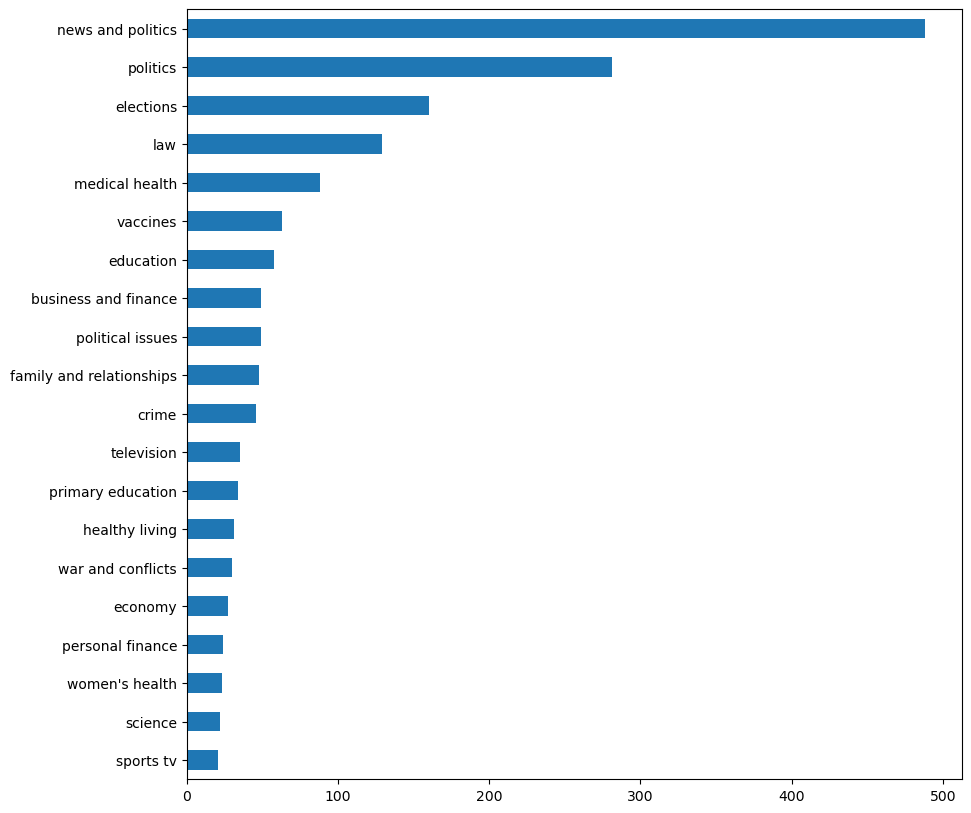

In [26]:
exp_categories['categories_prediction'].value_counts().head(20).sort_values().plot(kind='barh',figsize=(10,10)) 

plt.show()

<span style="color:blue">We are now able to see more categories within the selected Politics category like crime, elections, medical health, women's health, war and conflicts etc.</span>

<a id="summary"></a>
## 5. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library to:
1. Extract tokens, Parts of Speech, Lemmas etc
1. Extract Text Categories from a text corpus to understand what people are talking about.
</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-ecosystem-engineering/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2023 IBM Corporation 